In [1]:
using AutomotiveDrivingModels
using AutoViz
using Reactive
using Interact
using SplineUtils
using SplineRaceWay
using HierarchicalRecedingHorizonController
using NearestNeighbors


# import PyPlot

/Users/kyle/anaconda/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [2]:
# scene parameters
scene = Scene()
framerate = 24
Δt = 1.0/framerate # size of rendering timesteps
n_integration_sub_steps = 3 # sub steps for smoother integration
context = IntegratedContinuous(Δt, n_integration_sub_steps) # integrated continuous context

#car parameters
car_length = 4.8 # front wheel to back wheel
car_width = 2.5
v⁰  = 0.0 # initial velocity
δ⁰ = 0.0 # initical steering angle

############### INITIALIZE TRACK ################

lane_width = 8.0*DEFAULT_LANE_WIDTH
radius = 45.0
edge_buffer = 0.25
T_MAX = lane_width/2.0 - car_width/2.0 - edge_buffer # max allowable projection distance from center of lane
base_speed= 0.0

# spline control points
# Pts = 40*[0 -1 -2 -3 -3 -3 -2 -1 -1 -1 -2 -3 -4 -5 -5 -5 -5 -5 -5 -4 -3 -2 -1 -1 -1 0 1 1 1 2 3 4 5 5 5 5 5 5 5 4 3 3 3 3 2 1 0; 
#          0 0 0 0 -1 -2 -2 -2 -3 -4 -4 -4 -4 -4 -3 -2 -1 0 1 2 3 4 4 3 2 2 2 3 4 4 4 4 3 2 1 0 -1 -2 -3 -4 -3 -2 -1 0 0 0 0]
Pts = 40*[0 -1 -2 -3 -3.5 -3 -2 -1 -0.5 -1 -2 -3 -4 -5 -5.5 -5 -4.5 -5 -5 -4 -3 -2 -1 -1 -1 0 1 1 1 2 3 4 5 5 5 5 5 5 5 4 3 3 3 3 2 1 0; 
       0 0 0 0 -1 -2 -2 -2 -3 -4 -4 -4 -4 -4 -3 -2 -1 0 1 2 3 4 4 3 2 2 2 3 4 4 4 4 3 2 1 0 -1 -2 -3 -4 -3 -2 -1 0 0 0 0]

degree = 3 # degree of spline
num_points = 10001
num_samples = 420
lane_width = 20.0
track = Raceway(Pts,degree,num_points,num_samples,lane_width)

SplineRaceWay.Raceway(AutomotiveDrivingModels.AutoCore.Roadway(AutomotiveDrivingModels.AutoCore.RoadSegment[AutomotiveDrivingModels.AutoCore.RoadSegment(1,AutomotiveDrivingModels.AutoCore.Lane[AutomotiveDrivingModels.AutoCore.Lane(LaneTag(1, 1),AutomotiveDrivingModels.AutoCore.CurvePt[CurvePt({0.000, 0.000, 3.142}, 0.000, 0.000, NaN),CurvePt({-4.383, 0.000, 3.142}, 4.383, 0.000, NaN),CurvePt({-8.766, 0.000, 3.142}, 8.766, 0.000, NaN),CurvePt({-13.149, 0.000, 3.142}, 13.149, 0.000, NaN),CurvePt({-17.532, 0.000, 3.142}, 17.532, 0.000, NaN),CurvePt({-21.915, 0.000, 3.142}, 21.915, 0.000, NaN),CurvePt({-26.298, 0.000, 3.142}, 26.298, 0.000, NaN),CurvePt({-30.681, 0.000, 3.142}, 30.681, 0.000, NaN),CurvePt({-35.064, 0.000, 3.142}, 35.064, 0.000, NaN),CurvePt({-39.447, 0.000, 3.142}, 39.447, 0.000, NaN)  …  CurvePt({43.830, 0.000, 3.142}, 1797.023, 0.000, NaN),CurvePt({39.447, 0.000, 3.142}, 1801.406, 0.000, NaN),CurvePt({35.064, 0.000, 3.142}, 1805.789, 0.000, NaN),CurvePt({30.681, 0.000, 3

In [3]:
# # compute B spline
# T, tt, rx, ry = ClosedB_Spline(Pts, degree, num_points)
# # compute B spline derivative
# ṙx, ṙy = B_SplineDerivative(T,tt,Pts,degree)
# # compute theta 
# θ = atan2(ṙy,ṙx) # unit tangent vector
# # compute arc length s
# s = zeros(size(rx))
# s[2:end] = cumsum(sqrt(diff(rx).^2 + diff(ry).^2))
# # compute curvature
# k = diff(θ)./diff(s) # curvature
# # resample evenly along spline
# xP, yP, θP, sP, kP = ResampleSplineEven(rx,ry,θ,s,k,num_samples)

# # KDtree for projection onto roadway
# # tree = KDTree([xP';yP'])

# roadway, tree = GenSplineRoadway(xP,yP,θP,sP,kP,lane_width)

In [4]:
roadind1 = RoadIndex(CurveIndex(20,0),LaneTag(1,1))
roadind2 = RoadIndex(CurveIndex(17,0),LaneTag(1,1))
roadind3 = RoadIndex(CurveIndex(11,0),LaneTag(1,1))

vehstate1 = VehicleState(Frenet(roadind1, track.roadway), track.roadway, 0.0)
vehstate2 = VehicleState(Frenet(roadind2, track.roadway), track.roadway, 0.0)
vehstate3 = VehicleState(Frenet(roadind3, track.roadway), track.roadway, 0.0)

vehdef1 = VehicleDef(1,AgentClass.CAR, car_length, car_width)
vehdef2 = VehicleDef(2,AgentClass.CAR, car_length, car_width)
vehdef3 = VehicleDef(3,AgentClass.CAR, car_length, car_width)

push!(scene,Vehicle(vehstate1, vehdef1))
push!(scene,Vehicle(vehstate2, vehdef2))
push!(scene,Vehicle(vehstate3, vehdef3))

# models = Dict{Int, DriverModel}()
carcolors = Dict{Int, Colorant}()
carcolors[1] = colorant"red"
carcolors[2] = colorant"blue"
carcolors[3] = colorant"yellow"


# hrhc = HRHC(1,roadway,context)
track.models[1] = HRHC(1,track.roadway,context,ΔV₊=2.05,ΔV₋=4.05,Δδ=Float64(π)/12,V_MIN=0.0,V_MAX=115.0,V_STEPS=230,k=1)
track.models[2] = HRHC(2,track.roadway,context,ΔV₊=1.55,ΔV₋=4.05,Δδ=Float64(π)/12,V_MIN=0.0,V_MAX=125.0,V_STEPS=250,k=1)
track.models[3] = HRHC(3,track.roadway,context,ΔV₊=2.55,ΔV₋=4.05,Δδ=Float64(π)/12,V_MIN=0.0,V_MAX=130.0,V_STEPS=250,k=2)
actions = Array(DriveAction, length(scene))

track.obstacleMap = generateObstacleMap(scene, track.models)

Dict{Any,Any} with 3 entries:
  0 => Dict{Any,Any}(Pair{Any,Any}(2,[0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ;…
  2 => Dict{Any,Any}(Pair{Any,Any}(2,[0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ;…
  1 => Dict{Any,Any}(Pair{Any,Any}(2,[0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ;…

In [5]:
function drawsim(t, dt=NaN)
    # get_actions!(actions, scene, roadway, models)
    k_level = 0 # needs to be updated into a loop
    for k_level in 0:maximum([model.k for (id,model) in track.models])
        for (i, veh) in enumerate(scene)
            model = track.models[veh.def.id]
            observe!(model, scene, track.roadway, veh.def.id, track.tree, track.obstacleMap, k_level)
            actions[i] = rand(model)
        end
    end
    # tick!(scene, roadway, actions, models)
    for (veh, action) in zip(scene, actions)
        model = track.models[veh.def.id]
        context = action_context(model)
        veh.state = propagate(veh, action, context, track.roadway)
    end
    zoom = 5.0
    render(scene, track.roadway, cam=FitToContentCamera(), car_colors=carcolors)
#     render(scene, track.roadway, cam=SceneFollowCamera(zoom), car_colors=carcolors)

end

drawsim (generic function with 2 methods)

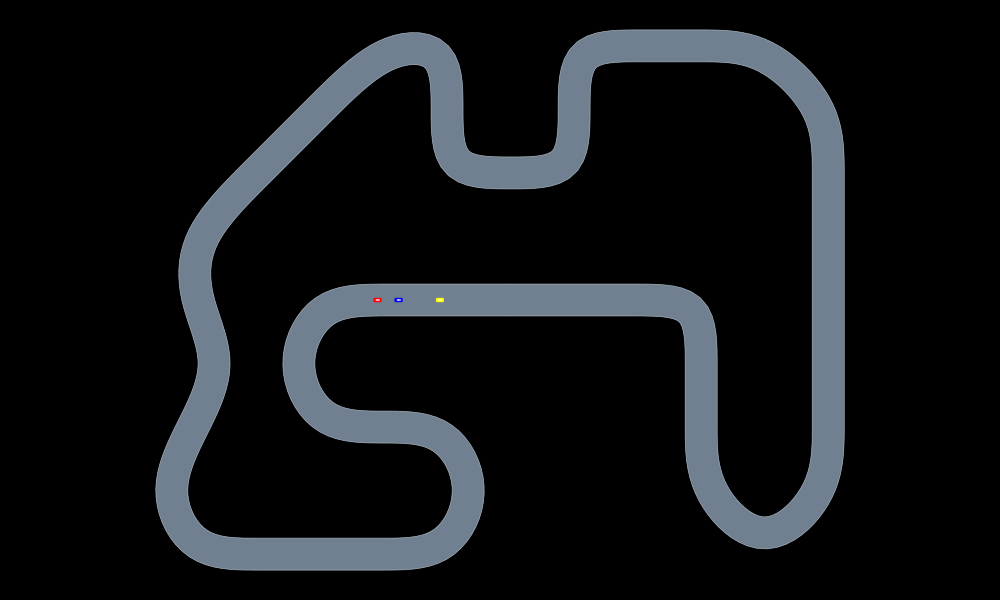

In [6]:
ticks = fps(framerate)
timestamps = map(_ -> time(), ticks)
map(drawsim, timestamps)

In [ ]:
trajectory = zeros(track.models[1].h,5)
out_of_bounds = false
objective = zeros(6,17)
eligibility_mask = zeros(6,17)
s = zeros(6,17)
t = zeros(6,17)
ϕ = zeros(6,17)
action_selected = false
cmd = (1,1)
abs_cmd = (1,1)

In [ ]:
steps = 1
for _ in 1:steps
    for k_level in 0:maximum([model.k for (id,model) in track.models])
        for (i, veh) in enumerate(scene)
            model = track.models[veh.def.id]
            observe!(model, scene, track.roadway, veh.def.id, track.tree, track.obstacleMap, k_level)
            actions[i] = rand(model)
        end
    end
    for (veh, action) in zip(scene, actions)
        model = track.models[veh.def.id]
        context = action_context(model)
        veh.state = propagate(veh, action, context, track.roadway)
    end
end

k_level = 1
hrhc = track.models[1]
state = scene.vehicles[hrhc.car_ID].state
hrhc.curve_ind = state.posF.roadind.ind.i
v = state.v # current v
hrhc.v = v

i = 0
for i in 0:(hrhc.h-1)
    if action_selected
#         @show i-1
        break # out of for loop
    end
    getLegalMoves!(hrhc, scene, h=hrhc.h-i)
    getSuccessorStates!(hrhc, scene)
    s,t,ϕ = loopProjectionKD(hrhc, scene, track.roadway, track.tree)
    objective = calculateObjective(hrhc, scene, track.roadway, track.tree, s, t, ϕ, track.obstacleMap, k_level, hrhc.h-i)

    while (action_selected==false) && (minimum(objective) != Inf)            
        index = indmin(objective) # find get a better method of optimizing this
        cmd = ind2sub(s, index)
        abs_cmd = (cmd[1]+hrhc.v_idx_low-1, cmd[2]+hrhc.δ_idx_low-1)

        # compute full trajectory up to horizon
        trajectory = computeTrajectory(hrhc, scene, abs_cmd, h=hrhc.h-i)

        # screen trajectory for collisions / validity
        out_of_bounds = screenTrajectory(trajectory, track.obstacleMap, scene, track.roadway, hrhc, track.tree, k_level)

        if out_of_bounds
            objective[index] = Inf
        else
            action_selected=true
            updateObstacleMap!(track.obstacleMap, k_level, hrhc.car_ID, trajectory)
        end
    end 
end

# hrhc.δ = hrhc.δ_cmds[abs_cmd[1], abs_cmd[2]]
# hrhc.v = hrhc.v_cmds[abs_cmd[1], abs_cmd[2]]

# next_state = VehicleState(VecSE2(trajectory[1,:]),roadway,hrhc.v)   
# hrhc.action = NextState(next_state) # action
plotHRHCInfo(hrhc,track.models,scene,track.roadway,trajectory,cmd,track.x,track.y,track.θ,s,t,ϕ,objective)

In [ ]:
# render(scene, track.roadway, cam=FitToContentCamera(), car_colors=carcolors)

In [ ]:
# plot_stϕ(hrhc,track.roadway,scene,track.x,track.y,track.θ,trajectory,s,t,ϕ,objective)

In [ ]:
# plotObjectiveHorizon(track.models[2],scene,track.roadway,track.tree,trajectory,track.obstacleMap,track.x,track.y,track.θ)

In [ ]:
function calculateObjective(hrhc, scene, roadway, tree, s, t, ϕ, obstacleMap, k_level, h; f_ϕ=0.0, f_t=0.1, f_tϕ=3.0)
    """
    Calculates the value of the optimization objective function for every state
      in hrhc.successor_states
    """
    state = scene.vehicles[hrhc.car_ID].state
    dS = s - state.posF.s
    dS = dS / maximum(dS) # normalize
    ϕMAX = Float64(π)/2

    # penalize large t (proximity to edge of track)
    cost_t = (exp(((10-h+f_t)*abs(t/hrhc.T_MAX).^2)) - 1)/exp(f_t)
    # penalize large ϕ (steering away from forward direction on the track)
    cost_ϕ = (exp(((10-h+f_ϕ)*abs(ϕ/ϕMAX).^2)) - 1)/exp(f_ϕ)
    # penalize when t and ϕ have the same sign
    A = [1 1; 1 1]
    cost_x = (((ϕ/ϕMAX)*A[1,1] + (t/hrhc.T_MAX)*A[2,1]).*(ϕ/ϕMAX) + ((ϕ/ϕMAX)*A[1,2] + (t/hrhc.T_MAX)*A[2,2]).*(t/hrhc.T_MAX))/2
    cost_tϕ = (exp(f_tϕ*cost_x) - 1)/exp(1)
    eligibility_mask = ((hrhc.successor_states[:,:,1] .== state.posG.x).*(hrhc.successor_states[:,:,2] .== state.posG.y))

    # obstacles
    collisionCost = zeros(size(cost_t))
    threshold_dist = hrhc.car_length*4 # must be at least this close before we care to calculate collision cost
    if k_level >= 1
        for (id,car) in obstacleMap[k_level - 1]
            if id != hrhc.car_ID
                state = scene.vehicles[hrhc.car_ID].state
                state2 = scene.vehicles[id].state
                diff = state.posG - state2.posG
                if norm([diff.x, diff.y]) < threshold_dist
                    pos = VecSE2(car[h,1:3]) # x,y,θ of opponent at time step h
                    ΔX = hrhc.successor_states[:,:,1] - pos.x # Δx, with opponent at origin
                    ΔY = hrhc.successor_states[:,:,2] - pos.y # Δy with opponent at origin
                    Δθ = hrhc.successor_states[:,:,3] - pos.θ # Δθ with opponent at origin
                    pts = [hrhc.car_length hrhc.car_length -hrhc.car_length -hrhc.car_length 0;
                        -hrhc.car_width hrhc.car_width hrhc.car_width -hrhc.car_width 0]/2.0
                    pX = zeros(size(pts,2),size(hrhc.successor_states,1),size(hrhc.successor_states,2))
                    pY = zeros(size(pX))
                    for i in 1:size(pts,2)
                        pX[i,:,:] = pts[1,i]*cos(Δθ) - pts[2,i]*sin(Δθ) + ΔX
                        pY[i,:,:] = pts[1,i]*sin(Δθ) + pts[2,i].*cos(Δθ) + ΔY
                    end

                    collisionFlag = (maximum((abs(pX) .< hrhc.car_length/2.0),1)[1,:,:]).*(maximum((abs(pY) .< hrhc.car_width/2.0),1)[1,:,:])
                    collisionCost = .001+collisionFlag./(minimum(abs(pX),1)[1,:,:].*minimum(abs(pY),1)[1,:,:])
                end
            end
        end
    end

    objective = cost_t + cost_ϕ + cost_tϕ + 1 - dS + collisionCost + Inf * eligibility_mask
    return objective
end

## Presentation Graphics

In [ ]:
indices = 60:70
perp_lines1 = zeros(2,length(track.x))
perp_lines2 = zeros(2,length(track.x))

perp_lines1[1,:] = track.x + (lane_width/2.0)*sin(track.θ)
perp_lines1[2,:] = track.y - (lane_width/2.0)*cos(track.θ)
perp_lines2[1,:] = track.x - (lane_width/2.0)*sin(track.θ)
perp_lines2[2,:] = track.y + (lane_width/2.0)*cos(track.θ)

PyPlot.figure()
PyPlot.scatter(track.x[indices],track.y[indices],color="crimson",s=50)
PyPlot.plot(track.x[indices],track.y[indices],color="crimson")
# PyPlot.plot(perp_lines1[1,indices],perp_lines1[2,indices],color="orange")
# PyPlot.plot(perp_lines2[1,indices],perp_lines2[2,indices],color="orange")
PyPlot.axis("equal")
PyPlot.axis("off")